- So far, if we want to run multiple services with docker, we've relied on doing `docker run` multiple times. Because we want to be as lazy as possible, we want to find a way to make this as easy as possible

- This is where docker compose comes in
    - Instead of typing `docker run` many times, we simply define a yaml file to orchestrate to spin-up of all my docker containers
    - Example:
        ```yaml
            services:
                web:
                    image: 'my-dockerhub-acct/my-webapp'
                database:
                    image: 'mongodb'
                messaging:
                    image: 'redis'
                orchestration:
                    image: 'ansible'
        ```
    - Then run `docker compose up` to run this yaml file
    - Note that all this is only applicable when running all of these containers in a single docker host


## Sample application with Docker

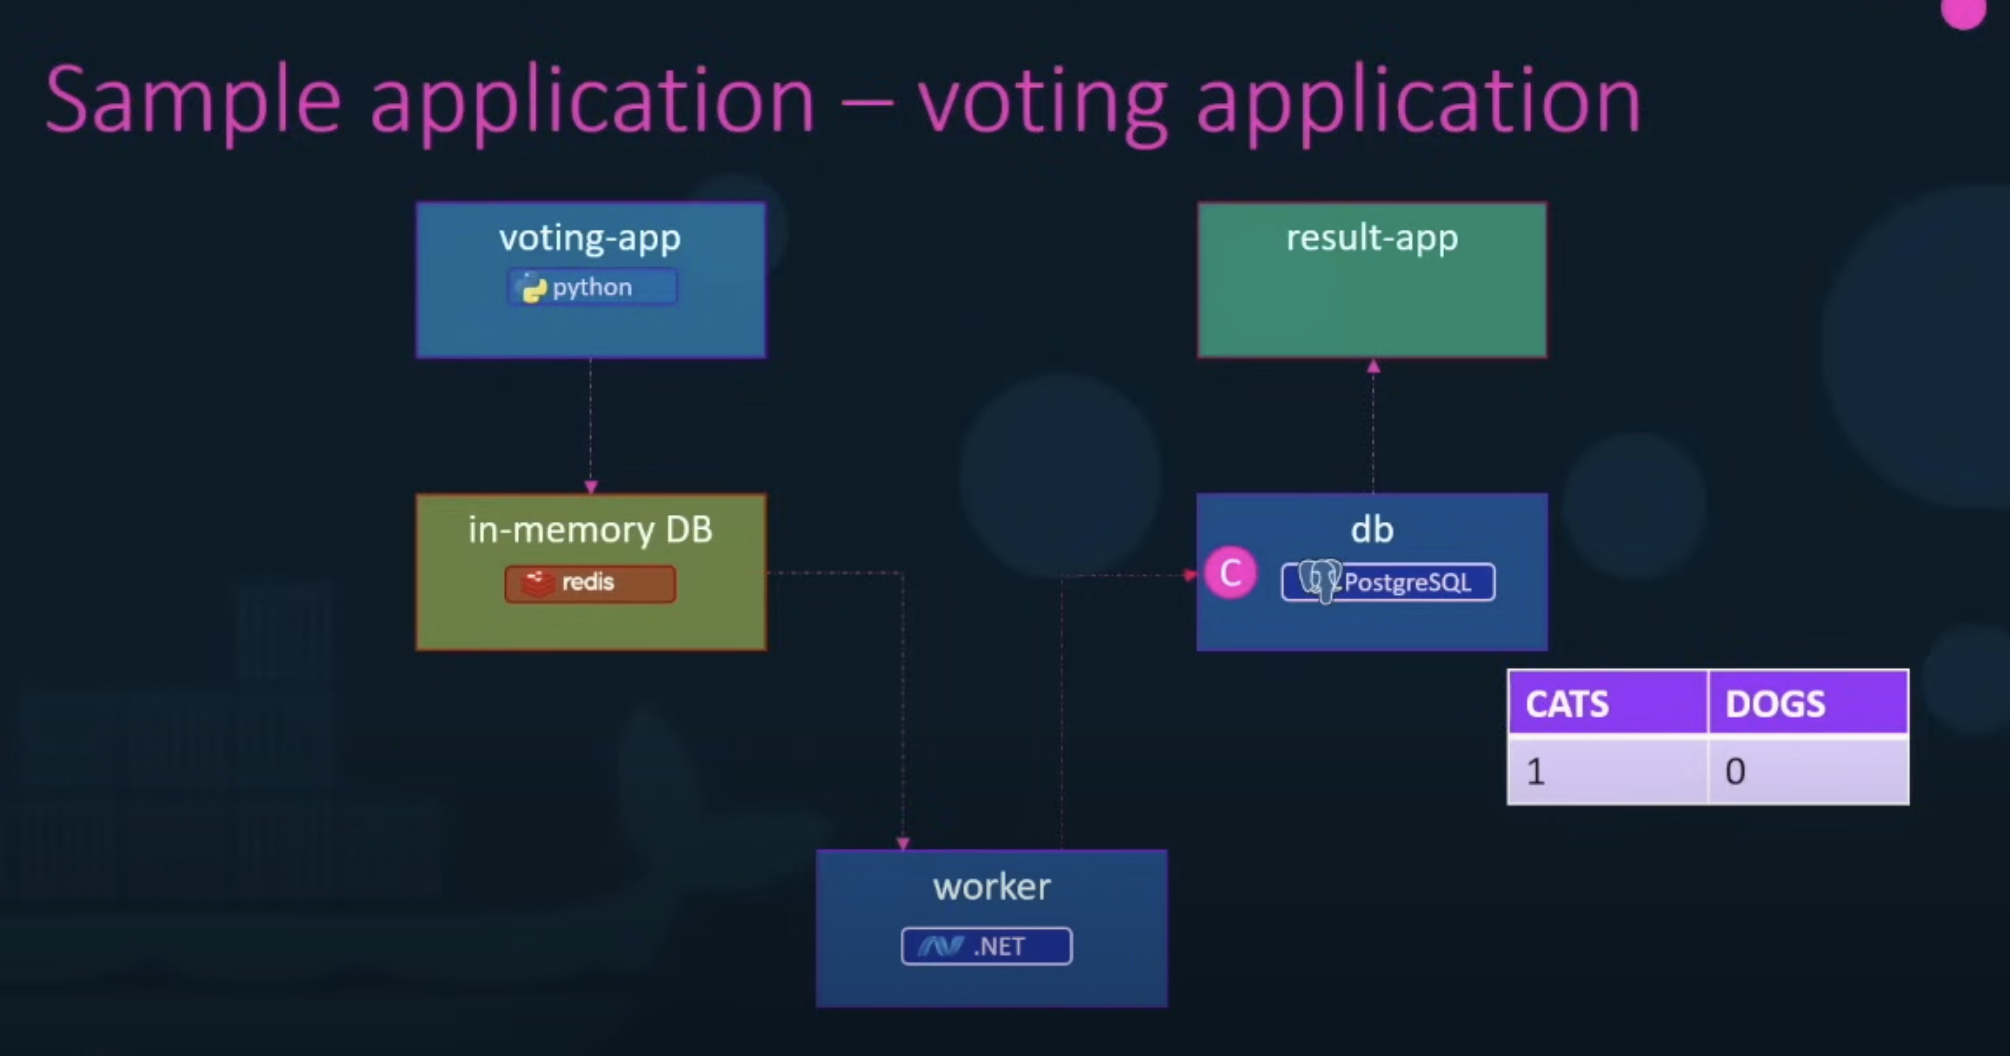

- How will we put this application stack together using a single docker engine using `docker run` / `docker compose`?

### Docker run

**WARNING**: This entire section is not actually recommended practise, and some parts are marked for deprecation. This just shows you what's possible for education purposes

- Steps
    - `docker run -d --name=redis redis`
        - Note that you want to name the containers that you deploy, so that you can refer to them for networking on docker's DNS
    - `docker run -d --name=db postgres:9.4`
    - `docker run -d --name=vote -p 5000:80 voting-app`
    - `docker run -d --name=result -p 5001:80 result-app`
    - `docker run -d --name=worker worker`

- If you go through these steps, it still won't work
    - Why? Because these containers are not in the same network, so they can't talk to each other
    - To do this, we use `--links`

- What does `--links` do? 
    - Creates an entry in the `/etc` host file of the specific container the parameter is appended to, and adds an entry with the specified host name with the internal IP of the specific container

- New Steps
    - `docker run -d --name=redis redis`
    - `docker run -d --name=db --link db:db postgres:9.4`
    - `docker run -d --name=vote -p 5000:80 --link redis:redis voting-app`
    - `docker run -d --name=result -p 5001:80 result-app`
    - `docker run -d --name=worker --link db:db --link redis:redis worker`

### Docker compose

- Doing `docker run` and manually drawing links to all the relevant containers is tiresome, and error prone
- Instead, let's try doing this as a fixed yaml file instead, then just run `docker compose up`

- Notes:
    - Can `docker compose` still work if the images are not yet built?
        - Yes! Just specify the directory to build using the `build` keyword
    - From version 2 onwards, `links` keyword is no longer needed in docker compose, because docker automatically creates a network for you to use and lets the apps communicate on it
    - From version 2 onwards, you can use `depends_on` property to properly start your containers 

```yaml
version: 3 #use version 3 of docker compose

services:
    redis:
        image: redis
    db:
        image: postgres:9.4
    vote:
        build: ./vote
        image: voting-app
        ports:
            - 5000:80
        depends_on:
            - redis
    result:
        build: ./result
        image: result-app
        ports:
            - 5001:80
    worker:
        image: worker
```

## Networking in docker compose

- Suppose we want to create a dedicated network for front end traffic, and one for backend traffic
- Then we connect the user facing application (voting app and result app) to the front end network, and all other components to the backend network
- We specify this in the following manner:

```yaml
version: 3 #use version 3 of docker compose

services:
    redis:
        image: redis
        networks:
            - back-end
    db:
        image: postgres:9.4
        networks:
            - back-end
    vote:
        build: ./vote
        image: voting-app
        ports:
            - 5000:80
        depends_on:
            - redis
        networks:
            - front-end
            - back-end
    result:
        build: ./result
        image: result-app
        ports:
            - 5001:80
        networks:
            - front-end
            - back-end
    worker:
        image: worker
        networks:
            - back-end

networks:
    front-end:
    back-end: 
```